In [13]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams

from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
from statsmodels.tsa.seasonal import seasonal_decompose


In [14]:
df = pd.read_csv("https://raw.githubusercontent.com/AileenNielsen/TimeSeriesAnalysisWithPython/master/data/AirPassengers.csv")


In [15]:
df['Month'] = pd.to_datetime(df['Month'], infer_datetime_format=True)
df = df.set_index(['Month'])

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_22456\2429695252.py:1: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['Month'] = pd.to_datetime(df['Month'], infer_datetime_format=True)


In [16]:
   
# df['#Passengers_diff'] = df['#Passengers'].diff(periods=12)
# df.info()

In [17]:
# df['#Passengers_diff'].fillna(method='backfill', inplace=True)


In [18]:
df.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


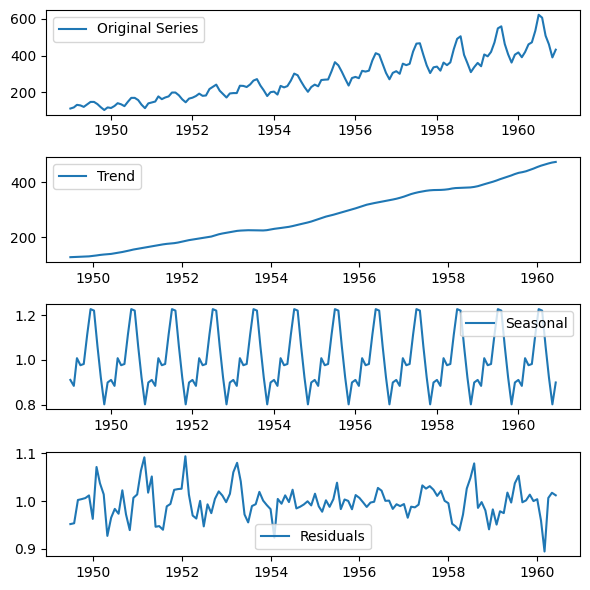

In [19]:
result = seasonal_decompose(df['#Passengers'], model='multiplicative', period=12)
trend = result.trend.dropna()
seasonal = result.seasonal.dropna()
residual = result.resid.dropna()

# Plot the decomposed components
plt.figure(figsize=(6,6))

plt.subplot(4, 1, 1)
plt.plot(df['#Passengers'], label='Original Series')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(trend, label='Trend')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(seasonal, label='Seasonal')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(residual, label='Residuals')
plt.legend()

plt.tight_layout()
plt.show()


In [20]:
df['month_index'] = df.index.month


In [21]:
df.head()

,#Passengers,month_index
Month,,
1949-01-01,112,1
1949-02-01,118,2
1949-03-01,132,3
1949-04-01,129,4
1949-05-01,121,5


In [22]:
SARIMAX_model = pm.auto_arima(df[['#Passengers']], exogenous=df[['month_index']],
						start_p=1, start_q=1,
						test='adf',
						max_p=3, max_q=3, m=12,
						start_P=0, seasonal=True,
						d=None, D=1,
						trace=False,
						error_action='ignore',
						suppress_warnings=True,
						stepwise=True)


In [31]:
   
def sarimax_forecast(SARIMAX_model, periods=24):
    # Forecast
    n_periods = periods
 
    forecast_df = pd.DataFrame({
        "month_index": pd.date_range(start=df.index[-1] + pd.DateOffset(months=1), periods=24, freq='MS').month
    }, index=pd.date_range(start=df.index[-1] + pd.DateOffset(months=1), periods=24, freq='MS'))

 
    fitted, confint = SARIMAX_model.predict(n_periods=n_periods,
                                            return_conf_int=True,
                                            exogenous=forecast_df[['month_index']])
    index_of_fc = pd.date_range(df.index[-1] + pd.DateOffset(months=1), periods=n_periods, freq='MS')
 
    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)
 
    # Plot
    plt.figure(figsize=(15, 7))
    plt.plot(df["#Passengers"], color='#1f76b4')
    plt.plot(fitted_series, color='darkgreen')
    plt.fill_between(lower_series.index,
                     lower_series,
                     upper_series,
                     color='k', alpha=.15)
 
    plt.title("SARIMAX - Forecast of Airline Passengers")
    plt.show()

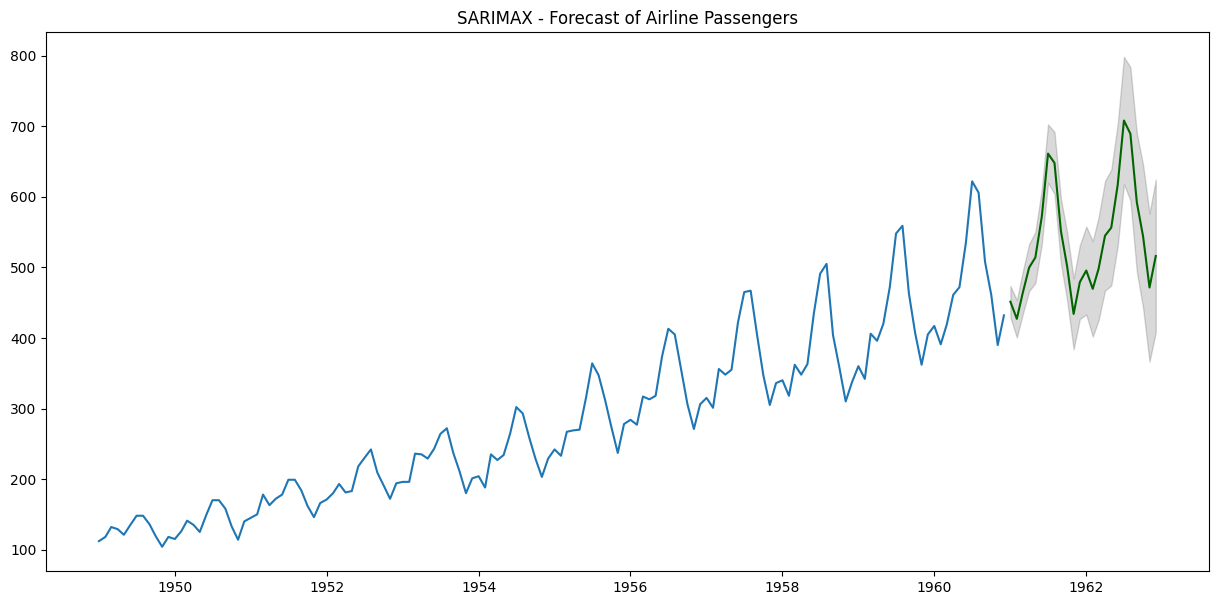

In [32]:
sarimax_forecast(SARIMAX_model, periods=24)
